In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.metrics import median_absolute_error
from sklearn.linear_model import Ridge
from category_encoders import OneHotEncoder
from sklearn.pipeline import make_pipeline

In [6]:
train = pd.read_parquet("train.parquet")
val = pd.read_parquet("val.parquet")

# Supervised embeddings

In [7]:
train2 = train.copy()
train2['WEEKDAY'] = train2['DATE_TIME'].dt.weekday
train2['HOUR'] = train2['DATE_TIME'].dt.hour
train2['MINUTE'] = train2['DATE_TIME'].dt.minute


val2 = val.copy()
val2['WEEKDAY'] = val2['DATE_TIME'].dt.weekday
val2['HOUR'] = val2['DATE_TIME'].dt.hour
val2['MINUTE'] = val2['DATE_TIME'].dt.minute



In [8]:
from category_encoders import OrdinalEncoder
encoder = OrdinalEncoder(cols=['SOURCE_KEY'])
train2['SOURCE_KEY_ENCODED'] = encoder.fit_transform(train2[['SOURCE_KEY']]) + 1
val2['SOURCE_KEY_ENCODED'] = encoder.transform(val2[['SOURCE_KEY']]) + 1

In [83]:
cats = ['SOURCE_KEY_ENCODED', 'WEEKDAY','HOUR', 'MINUTE']

In [10]:
import torch.nn as nn
import torch
import torch.functional as  F
import torch.optim as opt

In [11]:
?nn.Embedding

Init signature:
nn.Embedding(
    num_embeddings,
    embedding_dim,
    padding_idx=None,
    max_norm=None,
    norm_type=2.0,
    scale_grad_by_freq=False,
    sparse=False,
    _weight=None,
)
Docstring:     
A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices.
The input to the module is a list of indices, and the output is the corresponding
word embeddings.

Args:
    num_embeddings (int): size of the dictionary of embeddings
    embedding_dim (int): the size of each embedding vector
    padding_idx (int, optional): If given, pads the output with the embedding vector at :attr:`padding_idx`
                                     (initialized to zeros) whenever it encounters the index.
    max_norm (float, optional): If given, each embedding vector with norm larger than :attr:`max_norm`
                                is renormalized to have norm :attr:`max_norm`.
    norm_type

In [12]:
train2['SOURCE_KEY_ENCODED'].unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23])

In [13]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.e_source_key = nn.Embedding(24, 2, padding_idx=0)
    
    def forward(self, x):
        return self.e_source_key(x)

In [85]:
net = EmbeddingNet()

In [86]:
embeddings = net(torch.from_numpy(train2['SOURCE_KEY_ENCODED'].unique()).long())

In [88]:
embeddings

tensor([[-2.0866, -0.5419],
        [ 0.1249, -0.1588],
        [-0.8100,  0.5949],
        [-0.2144, -0.5316],
        [ 1.7652,  0.9610],
        [-0.1260,  0.6448],
        [-1.6232, -1.7484],
        [-0.7369,  0.2622],
        [ 1.5569,  0.3554],
        [-0.9860, -0.7808],
        [ 1.8083,  0.3968],
        [-0.1660, -0.0689],
        [-0.1033, -0.2115],
        [ 1.5094,  1.1614],
        [ 2.3129, -0.2622],
        [-0.9381, -0.0387],
        [ 0.5416,  0.8399],
        [ 0.8189,  0.0175],
        [ 0.7753,  0.9466],
        [ 0.5946, -0.5678],
        [ 0.4711, -0.9900],
        [ 0.1403, -1.3735]], grad_fn=<EmbeddingBackward>)

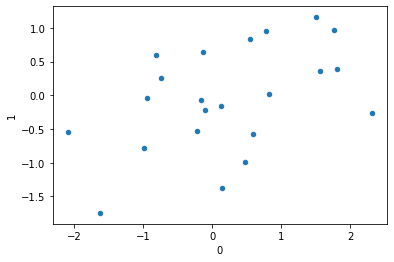

In [89]:
pd.DataFrame(embeddings.detach().numpy()).plot.scatter(x=0,y=1)

# Todos os embeddings
- um para cada feature ou 1 para a combinação? teste!

In [32]:
class EmbeddingNet2(nn.Module):
    def __init__(self):
        super(EmbeddingNet2, self).__init__()
        self.e_source_key = nn.Embedding(24, 2, padding_idx=0)
        self.e_weekday = nn.Embedding(7, 2, padding_idx=0)
        self.e_hour = nn.Embedding(24, 2, padding_idx=0)
        self.e_minute = nn.Embedding(60, 2, padding_idx=0)
        
        self.out = nn.Linear(8, 1)
    
    def forward(self, x, return_embeddings=False):
        e_source_key = self.e_source_key(x[:,0])
        e_weekday = self.e_weekday(x[:,1])
        e_hour = self.e_hour(x[:,2])
        e_minute = self.e_minute(x[:,3])
        
        x = torch.cat([e_source_key, e_weekday, e_hour, e_minute], dim=-1)
        #print(x.shape)
        x = self.out(x)
        
        if return_embeddings:
            return e_source_key, e_weekday, e_hour, e_minute
        return x
        

In [90]:
net = EmbeddingNet2().cuda()
criterion = nn.L1Loss()
optimizer = opt.Adam(net.parameters(), lr=1e-4)

y = torch.from_numpy(train2['Y4WIN'].values.reshape(-1,1))
y_cuda = y.cuda()
for e in range(5000):
    optimizer.zero_grad()
    x = torch.from_numpy(train2[cats].values).cuda()
    p = net(x).cuda()
    loss = criterion(p, y_cuda)
    #print(loss.item())
    
    loss.backward()
    optimizer.step()
    
    p_numpy = p.cpu().detach().numpy()
    if e % 1000 == 0:
        print(median_absolute_error(y, p_numpy))
        
# nem overfita, modelo underfitted, pouca capacidade

13.52601868574424
13.384167039111489
13.10701458347554
12.561923257299348
11.906733504220611


In [92]:
net(x, return_embeddings=True)

(tensor([[-0.1883, -0.5056],
         [ 2.4396, -1.2802],
         [ 0.8818, -0.3720],
         ...,
         [ 0.4216, -1.1732],
         [ 0.4367, -1.1884],
         [ 0.4571, -0.4297]], device='cuda:0', grad_fn=<EmbeddingBackward>),
 tensor([[-0.2321,  1.7971],
         [-0.2321,  1.7971],
         [-0.2321,  1.7971],
         ...,
         [-0.5750,  1.5795],
         [-0.5750,  1.5795],
         [-0.5750,  1.5795]], device='cuda:0', grad_fn=<EmbeddingBackward>),
 tensor([[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [-0.1692, -0.0902],
         [-0.1692, -0.0902],
         [-0.1692, -0.0902]], device='cuda:0', grad_fn=<EmbeddingBackward>),
 tensor([[ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.0000,  0.0000],
         ...,
         [-0.7612, -0.8294],
         [-0.7612, -0.8294],
         [-0.7612, -0.8294]], device='cuda:0', grad_fn=<EmbeddingBackward>))